In [3]:
import pandas as pd
from pathlib import Path
path = Path("C:\\Users\\manch\\OneDrive\\Documents\\DEV\\MachineLearning\\datasets\\CTA_-_Ridership_-_Daily_Boarding_Totals_20241230.csv")

df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"] #shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1) # no need for total, it's just bus+ rail
df = df.drop_duplicates() # remove duplicated months (2011-10and 2014-07)
df

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2024-10-27,U,312965,215594
2024-10-28,W,611041,389359
2024-10-29,W,652674,444706


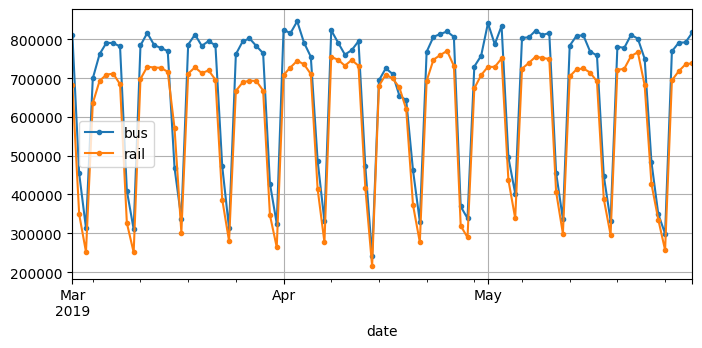

In [4]:
import matplotlib.pyplot as plt
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8,3.5))
plt.show()


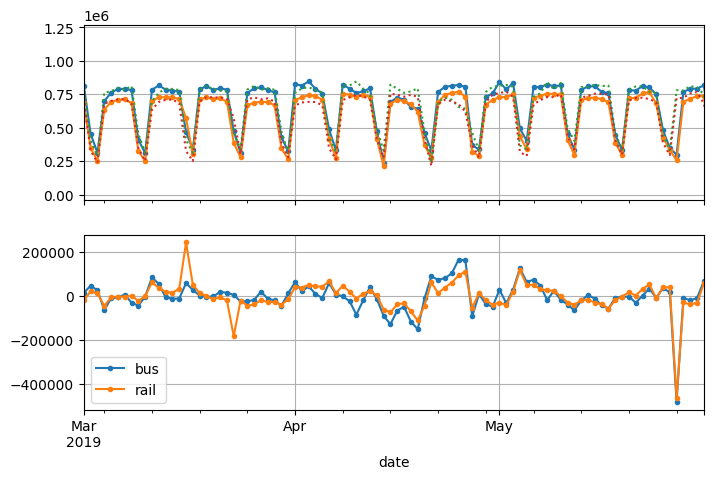

In [5]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".") # original timeseries
df.shift(7).plot(ax=axs[0], grid=True, legend=False,linestyle=":") # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".") # 7-day differencetime series
plt.show()


In [6]:
diff_7.abs().mean()


bus     43915.608696
rail    42143.271739
dtype: float64

In [7]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()


bus     0.082938
rail    0.089948
dtype: float64

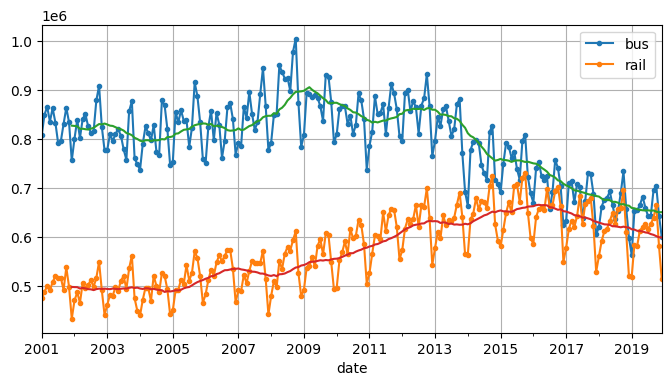

In [8]:
period = slice("2001", "2019")
df_monthly = df.resample('ME').mean(numeric_only=True) # compute the mean for eachmonth
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()


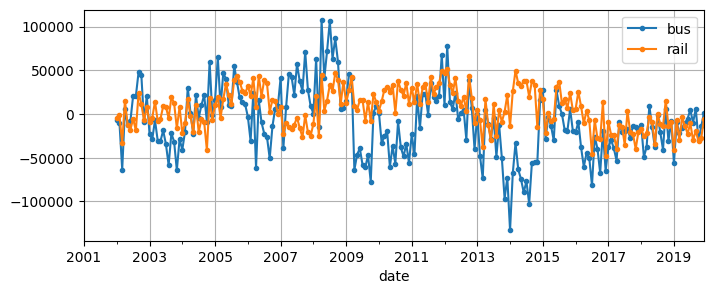

In [9]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()


In [143]:
from statsmodels.tsa.arima.model import ARIMA
origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
 order=(1, 0, 0),
 seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast() # returns 427,758.6

In [144]:
y_pred

2019-06-01    427758.626222
Freq: D, dtype: float64

In [145]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today], # train on data upto "today"
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 7))
    model = model.fit() # note that we retrain the model everyday!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)
y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean() #returns 32,040.7

C:\Users\manch\AppData\Local\Temp\ipykernel_16956\2134459007.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\manch\AppData\Local\Temp\ipykernel_16956\2134459007.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\manch\AppData\Local\Temp\ipykernel_16956\2134459007.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\User

KeyboardInterrupt: 

In [11]:
mae

32040.720090488467

Use keras to prepare data into sequences

In [14]:
import tensorflow as tf
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
 my_series,
 targets=my_series[3:], # the targets are 3 steps into thefuture
 sequence_length=3,
 batch_size=2
)


In [21]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

In [24]:
for window_dataset in tf.data.Dataset.range(6).window(4,shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()


0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [25]:
for window_dataset in tf.data.Dataset.range(6).window(4,shift=1,drop_remainder=True):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 


In [27]:
dataset = tf.data.Dataset.range(6).window(4, shift=1,
drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset:window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")


[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [28]:
def to_windows(dataset, length):
 dataset = dataset.window(length, shift=1,drop_remainder=True)
 return dataset.flat_map(lambda window_ds:window_ds.batch(length))


In [29]:
dataset = to_windows(tf.data.Dataset.range(6), 4) # 3 inputs+ 1 target = 4
dataset = dataset.map(lambda window: (window[:-1],window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

In [10]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6


In [ ]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                            rail_train.to_numpy(),
                                                            targets=rail_train[seq_length:],
                                                            sequence_length=seq_length,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            seed=42
                                                        )
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                            rail_valid.to_numpy(),
                                                            targets=rail_valid[seq_length:],
                                                            sequence_length=seq_length,
                                                            batch_size=32
                                                        )

test_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                            rail_test.to_numpy(),
                                                            targets=rail_test[seq_length:],
                                                            sequence_length=seq_length,
                                                            batch_size=32
                                                        )

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[seq_length])])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt,metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds,epochs=500,callbacks=[early_stopping_cb])


Epoch 1/500


C:\Users\manch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2528 - mae: 0.6094 - val_loss: 0.0120 - val_mae: 0.1212
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - mae: 0.1573 - val_loss: 0.0068 - val_mae: 0.0929
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - mae: 0.1084 - val_loss: 0.0059 - val_mae: 0.0836
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - mae: 0.0963 - val_loss: 0.0047 - val_mae: 0.0725
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - mae: 0.0804 - val_loss: 0.0054 - val_mae: 0.0759
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0821 - val_loss: 0.0043 - val_mae: 0.0685
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mae: 0.0755 - val_loss: 0.0041 - val_mae: 0.0669
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mae: 0.0709 - val_loss: 0.0040 - val_mae: 0.0660
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - mae: 0.0

In [17]:
# Get MAE values for training and validation
mae_values = history.history['mae']  # training MAE
val_mae_values = history.history['val_mae']  # validation MAE

# Get loss values
loss_values = history.history['loss']  # training loss
val_loss_values = history.history['val_loss']  # validation loss

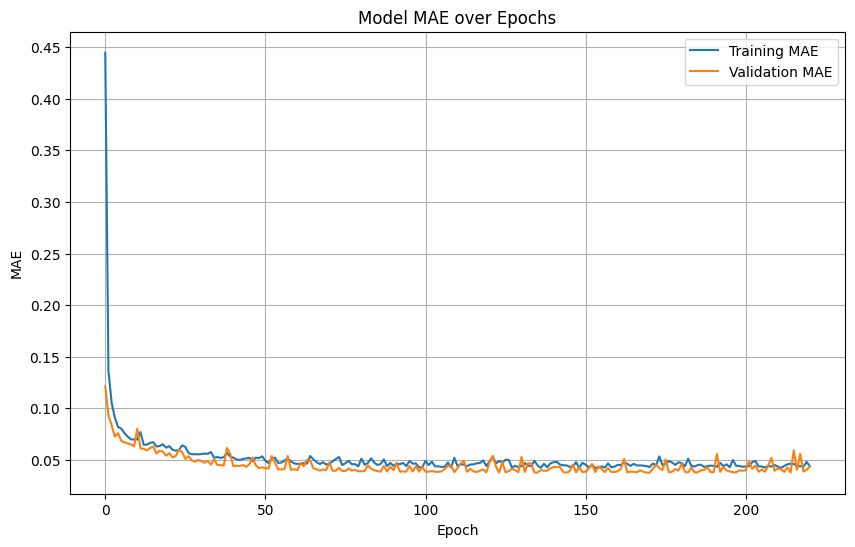

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mae_values, label='Training MAE')
plt.plot(val_mae_values, label='Validation MAE')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Get predictions
test_predictions = model.predict(valid_ds)

# Since we're using a sequence length of 56, our predictions start at index 56
# We need to align the predictions with the actual values
actual_values = rail_valid[seq_length:].values
mae = (pd.DataFrame(test_predictions*1e6) - pd.DataFrame(actual_values*1e6)).abs().mean() 
mae

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


0    37568.678454
dtype: float64

A basic RNN one recurent layer one recurrent neuron

Input Shape of the RNN
The input to an RNN typically has the following dimensions:

Input Shape=(Batch Size,Sequence Length,Feature Dimension)


In [39]:
df.columns

Index(['day_type', 'bus', 'rail'], dtype='object')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
seq_length = 56
batch_size = 32
learning_rate = 0.02
epochs = 500

# Reshape data for PyTorch
train_data = rail_train.to_numpy().reshape(-1, 1)
valid_data = rail_valid.to_numpy().reshape(-1, 1)

X_train = torch.tensor(
    [train_data[i:i + seq_length] for i in range(len(train_data) - seq_length)],
    dtype=torch.float32
)  # Remove .unsqueeze(-1)

y_train = torch.tensor(train_data[seq_length:], dtype=torch.float32).unsqueeze(-1)

X_valid = torch.tensor(
    [valid_data[i:i + seq_length] for i in range(len(valid_data) - seq_length)],
    dtype=torch.float32
)  # Remove .unsqueeze(-1)

y_valid = torch.tensor(valid_data[seq_length:], dtype=torch.float32).unsqueeze(-1)


# Debugging shape check
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")


train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=1, batch_first=True)
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last output
        return out
    
class SimpleRNNModel(nn.Module):
    def __init__(self):
        super(SimpleRNNModel, self).__init__()
        # RNN layer: input_dim=1 (univariate), hidden_dim=32
        self.rnn = nn.RNN(input_size=1, hidden_size=32, batch_first=True)  
        # Dense layer: maps 32 hidden units to 1 output
        self.fc = nn.Linear(32, 1)
        
    
    def forward(self, x):
        # RNN forward pass
        rnn_output, _ = self.rnn(x)  # rnn_output shape: (batch_size, seq_length, hidden_size)
        # Fully connected layer applied to the last time step of each sequence
        out = self.fc(rnn_output[:, -1, :])  # Shape: (batch_size, 1)
        return out

# Initialize model, loss, and optimizer
model = SimpleRNN().to(device)
criterion = nn.HuberLoss(delta=1)
#criterion = nn.MSELoss()
#criterion = nn.GaussianNLLLoss()
#criterion = nn.L1Loss()


optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
# Option 1: Adam (most reliable)
#optimizer = optim.Adam(model.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-8)  # Numerical stability

# Option 2: RMSprop (good for RNNs)
#optimizer = optim.RMSprop(model.parameters(),lr=0.001,alpha=0.99,eps=1e-8)
#optimizer = optim.Adagrad(model.parameters(), lr=0.01)


# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}")

# Evaluate on validation set
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for X_batch, y_batch in valid_loader:
        X_batch = X_batch.to(device)
        predictions.append(model(X_batch).cpu())
        actuals.append(y_batch)


# Flatten predictions and actuals to match dimensions
predictions = torch.cat(predictions).numpy().squeeze()  # Remove extra dimensions
actuals = torch.cat(actuals).numpy().squeeze()          # Remove extra dimensions

# Rescale if necessary (e.g., multiplying by 1e6)
predictions = predictions * 1e6
actuals = actuals * 1e6

# Ensure they are 2D for DataFrame
predictions_df = pd.DataFrame(predictions.reshape(-1, 1))
actuals_df = pd.DataFrame(actuals.reshape(-1, 1))

# Calculate Mean Absolute Error (MAE)
mae = (predictions_df - actuals_df).abs().mean().values[0]
print(f"Mean Absolute Error (MAE): {mae}")


X_train shape: torch.Size([1040, 56, 1]), y_train shape: torch.Size([1040, 1, 1])
X_valid shape: torch.Size([95, 56, 1]), y_valid shape: torch.Size([95, 1, 1])
Epoch 1/500, Loss: 0.0184
Epoch 2/500, Loss: 0.0177
Epoch 3/500, Loss: 0.0171
Epoch 4/500, Loss: 0.0170
Epoch 5/500, Loss: 0.0167
Epoch 6/500, Loss: 0.0167
Epoch 7/500, Loss: 0.0167
Epoch 8/500, Loss: 0.0166
Epoch 9/500, Loss: 0.0167
Epoch 10/500, Loss: 0.0165
Epoch 11/500, Loss: 0.0165
Epoch 12/500, Loss: 0.0165
Epoch 13/500, Loss: 0.0166
Epoch 14/500, Loss: 0.0166
Epoch 15/500, Loss: 0.0166
Epoch 16/500, Loss: 0.0166
Epoch 17/500, Loss: 0.0166
Epoch 18/500, Loss: 0.0166
Epoch 19/500, Loss: 0.0166
Epoch 20/500, Loss: 0.0166
Epoch 21/500, Loss: 0.0166
Epoch 22/500, Loss: 0.0164
Epoch 23/500, Loss: 0.0166
Epoch 24/500, Loss: 0.0166
Epoch 25/500, Loss: 0.0167
Epoch 26/500, Loss: 0.0167
Epoch 27/500, Loss: 0.0165
Epoch 28/500, Loss: 0.0165
Epoch 29/500, Loss: 0.0165
Epoch 30/500, Loss: 0.0165
Epoch 31/500, Loss: 0.0165
Epoch 32/500

KeyboardInterrupt: 

In [152]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
seq_length = 56
batch_size = 32
learning_rate = 0.02
epochs = 500

# Reshape data for PyTorch
train_data = rail_train.to_numpy().reshape(-1, 1)
valid_data = rail_valid.to_numpy().reshape(-1, 1)

X_train = torch.tensor(
    [train_data[i:i + seq_length] for i in range(len(train_data) - seq_length)],
    dtype=torch.float32
)
y_train = torch.tensor(
    train_data[seq_length:], dtype=torch.float32
)

X_valid = torch.tensor(
    [valid_data[i:i + seq_length] for i in range(len(valid_data) - seq_length)],
    dtype=torch.float32
)
y_valid = torch.tensor(
    valid_data[seq_length:], dtype=torch.float32
)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=1, batch_first=True)
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last output
        return out
class SimpleRNNModel(nn.Module):
    def __init__(self):
        super(SimpleRNNModel, self).__init__()
        # RNN layer: input_dim=1 (univariate), hidden_dim=32
        self.rnn = nn.RNN(input_size=1, hidden_size=32, num_layers= 1,batch_first=True)  
        # Dense layer: maps 32 hidden units to 1 output
        self.fc = nn.Linear(32, 1)
        
    
    def forward(self, x):
        # RNN forward pass
        rnn_output, _ = self.rnn(x)  # rnn_output shape: (batch_size, seq_length, hidden_size)
        # Fully connected layer applied to the last time step of each sequence
        out = self.fc(rnn_output[:, -1, :])  # Shape: (batch_size, 1)
        return out
    
    def fit(self):
        # Initialize model, loss, and optimizer
        model = SimpleRNNModel().to(device)
        criterion = nn.HuberLoss(delta=1)
        #criterion = nn.MSELoss()
        #criterion = nn.L1Loss()


        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) #momemntum is like a force that helps escapae the local minimum imagine a p ball moving in the optimization plane
        #optimizer = optim.Adam(model.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-8)  # Numerical stability
        #optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
        #optimizer = optim.Adagrad(model.parameters(), lr=0.01)
        #optimizer = optim.RMSprop(model.parameters(),lr=0.001,alpha=0.99,eps=1e-8)





        # Training loop
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}")

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            predictions = []
            actuals = []
            for X_batch, y_batch in valid_loader:
                X_batch = X_batch.to(device)
                predictions.append(model(X_batch).cpu())
                actuals.append(y_batch)
        predictions = torch.cat(predictions).numpy()
        actuals = torch.cat(actuals).numpy()
        return predictions,actuals

# Calculate MAE
mae = (abs(predictions - actuals)).mean()
print(f"MAE: {mae:.2f}")


Epoch 1/500, Loss: 0.0531
Epoch 2/500, Loss: 0.0155
Epoch 3/500, Loss: 0.0142
Epoch 4/500, Loss: 0.0137
Epoch 5/500, Loss: 0.0131
Epoch 6/500, Loss: 0.0127
Epoch 7/500, Loss: 0.0121
Epoch 8/500, Loss: 0.0116
Epoch 9/500, Loss: 0.0112
Epoch 10/500, Loss: 0.0105
Epoch 11/500, Loss: 0.0097
Epoch 12/500, Loss: 0.0089
Epoch 13/500, Loss: 0.0085
Epoch 14/500, Loss: 0.0083
Epoch 15/500, Loss: 0.0079
Epoch 16/500, Loss: 0.0077
Epoch 17/500, Loss: 0.0075
Epoch 18/500, Loss: 0.0073
Epoch 19/500, Loss: 0.0075
Epoch 20/500, Loss: 0.0070
Epoch 21/500, Loss: 0.0068
Epoch 22/500, Loss: 0.0066
Epoch 23/500, Loss: 0.0065
Epoch 24/500, Loss: 0.0064
Epoch 25/500, Loss: 0.0063
Epoch 26/500, Loss: 0.0059
Epoch 27/500, Loss: 0.0058
Epoch 28/500, Loss: 0.0055
Epoch 29/500, Loss: 0.0055
Epoch 30/500, Loss: 0.0052
Epoch 31/500, Loss: 0.0050
Epoch 32/500, Loss: 0.0048
Epoch 33/500, Loss: 0.0046
Epoch 34/500, Loss: 0.0045
Epoch 35/500, Loss: 0.0045
Epoch 36/500, Loss: 0.0042
Epoch 37/500, Loss: 0.0044
Epoch 38/5

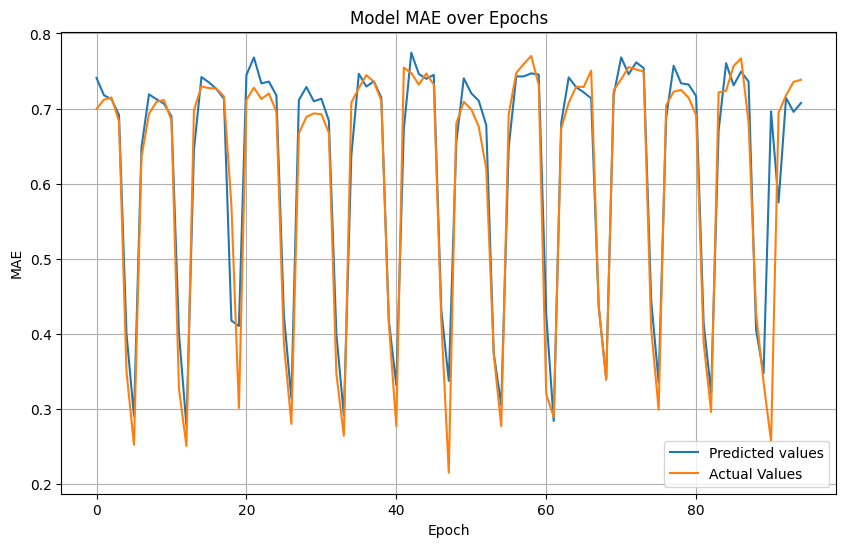

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predicted values')
plt.plot(actuals, label='Actual Values')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [154]:

# Rescale if necessary (e.g., multiplying by 1e6)
predictions = predictions * 1e6
actuals = actuals * 1e6

# Ensure they are 2D for DataFrame
predictions_df = pd.DataFrame(predictions.reshape(-1, 1))
actuals_df = pd.DataFrame(actuals.reshape(-1, 1))

# Calculate Mean Absolute Error (MAE)
mae = (predictions_df - actuals_df).abs().mean().values[0]
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 33139.828125


In [11]:
def ProcessTorchData(training_data,validation_data,seq_length,batch_size):
    # Reshape data for PyTorch
    train_data = training_data.to_numpy().reshape(-1, 1)
    valid_data = validation_data.to_numpy().reshape(-1, 1)

    X_train = torch.tensor(
                                [train_data[i:i + seq_length] for i in range(len(train_data) - seq_length)],
                                dtype=torch.float32
                            )
    y_train = torch.tensor(
                                train_data[seq_length:], dtype=torch.float32
                            )

    X_valid = torch.tensor(
                                [valid_data[i:i + seq_length] for i in range(len(valid_data) - seq_length)],
                                dtype=torch.float32
                            )
    y_valid = torch.tensor(
                                valid_data[seq_length:], dtype=torch.float32
                            )

    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    return train_loader,valid_loader

    

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class SimpleRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, dropout=0.2):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0  # Dropout applies only if `num_layers > 1`
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)  # Shape: (batch_size, seq_length, hidden_size)
        out = self.fc(rnn_output[:, -1, :])  # Only the last time step's output
        return out

class RNNTrainer:
    loss_functions = {
        "HuberLoss": nn.HuberLoss(delta=1),
        "MSELoss": nn.MSELoss(),
        "L1Loss": nn.L1Loss(),
    }
    
    optimizors = {
        "SGD": lambda model_params, lr: optim.SGD(model_params, lr=lr, momentum=0.9),
        "Adam": lambda model_params, lr: optim.Adam(model_params, lr=lr),
        "RMSprop": lambda model_params, lr: optim.RMSprop(model_params, lr=lr),
    }

    def __init__(self, model, train_loader, valid_loader, loss_f, optimizor, learning_rate=0.01, epochs=500):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.epochs = epochs
        
        if loss_f not in self.loss_functions:
            raise ValueError(f"Invalid loss function '{loss_f}'. Available options are: {list(self.loss_functions.keys())}")
        
        if optimizor not in self.optimizors:
            raise ValueError(f"Invalid optimizer '{optimizor}'. Available options are: {list(self.optimizors.keys())}")

        self.criterion = self.loss_functions[loss_f]
        self.optimizer = self.optimizors[optimizor](self.model.parameters(), lr=learning_rate)

    @classmethod
    def available_options(cls):
        return {
            "loss_f": list(cls.loss_functions.keys()),
            "optimizors": list(cls.optimizors.keys()),
        }

    def fit(self):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for X_batch, y_batch in self.train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                self.optimizer.zero_grad()
                y_pred = self.model(X_batch)
                loss = self.criterion(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            train_loss /= len(self.train_loader)
            print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {train_loss:.4f}")

    def evaluate(self):
        self.model.eval()
        predictions, actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in self.valid_loader:
                X_batch = X_batch.to(self.device)
                predictions.append(self.model(X_batch).cpu())
                actuals.append(y_batch)

        predictions = torch.cat(predictions).numpy()
        actuals = torch.cat(actuals).numpy()
        return predictions, actuals


In [30]:
# Load and preprocess data
seq_length = 56
batch_size = 32

train_loader, valid_loader = ProcessTorchData(rail_train, rail_valid, seq_length, batch_size)

# Initialize the model and trainer
model = SimpleRNNModel(input_size=1, hidden_size=32, num_layers=1, dropout=0.2)
trainer = RNNTrainer(model, train_loader, valid_loader,loss_f="HuberLoss",optimizor="SGD",learning_rate=0.01, epochs=500)

# Train the model
trainer.fit()

# Evaluate the model
predictions, actuals = trainer.evaluate()


Epoch 1/100, Loss: 0.0388
Epoch 2/100, Loss: 0.0166
Epoch 3/100, Loss: 0.0158
Epoch 4/100, Loss: 0.0155
Epoch 5/100, Loss: 0.0152
Epoch 6/100, Loss: 0.0148
Epoch 7/100, Loss: 0.0146
Epoch 8/100, Loss: 0.0145
Epoch 9/100, Loss: 0.0143
Epoch 10/100, Loss: 0.0139
Epoch 11/100, Loss: 0.0139
Epoch 12/100, Loss: 0.0135
Epoch 13/100, Loss: 0.0133
Epoch 14/100, Loss: 0.0132
Epoch 15/100, Loss: 0.0130
Epoch 16/100, Loss: 0.0128
Epoch 17/100, Loss: 0.0128
Epoch 18/100, Loss: 0.0125
Epoch 19/100, Loss: 0.0124
Epoch 20/100, Loss: 0.0122
Epoch 21/100, Loss: 0.0120
Epoch 22/100, Loss: 0.0118
Epoch 23/100, Loss: 0.0116
Epoch 24/100, Loss: 0.0113
Epoch 25/100, Loss: 0.0111
Epoch 26/100, Loss: 0.0108
Epoch 27/100, Loss: 0.0106
Epoch 28/100, Loss: 0.0103
Epoch 29/100, Loss: 0.0100
Epoch 30/100, Loss: 0.0096
Epoch 31/100, Loss: 0.0092
Epoch 32/100, Loss: 0.0088
Epoch 33/100, Loss: 0.0084
Epoch 34/100, Loss: 0.0081
Epoch 35/100, Loss: 0.0079
Epoch 36/100, Loss: 0.0077
Epoch 37/100, Loss: 0.0077
Epoch 38/1

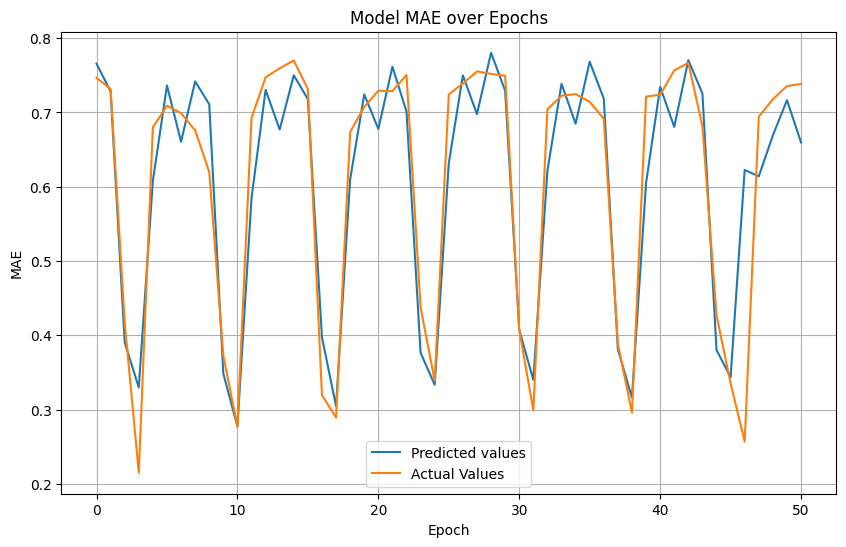

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predicted values')
plt.plot(actuals, label='Actual Values')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [29]:

# Rescale if necessary (e.g., multiplying by 1e6)
predictions = predictions * 1e6
actuals = actuals * 1e6

# Ensure they are 2D for DataFrame
predictions_df = pd.DataFrame(predictions.reshape(-1, 1))
actuals_df = pd.DataFrame(actuals.reshape(-1, 1))

# Calculate Mean Absolute Error (MAE)
mae = (predictions_df - actuals_df).abs().mean().values[0]
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 48903.890625


In [31]:
#Custom cross validation algorithm to find the combination of loss and optimizer functions
loss_functions = [
                    "HuberLoss",
                    "MSELoss",
                    "L1Loss"
                ]

optimizors = [
                "SGD",
                "Adam",
                "RMSprop"
            ]

results     ={
                "option_1":{
                            "loss":"loss",
                            "opt":"opt",
                            "mae":"mae"
                            }
}

options=0
for loss_name in loss_functions:
    for opt_name in optimizors:
        # Load and preprocess data
        seq_length = 56
        batch_size = 32

        train_loader, valid_loader = ProcessTorchData(rail_train, rail_valid, seq_length, batch_size)

        # Initialize the model and trainer
        model = SimpleRNNModel(input_size=1, hidden_size=32, num_layers=1, dropout=0.2)
        trainer = RNNTrainer(model, train_loader, valid_loader,loss_f=loss_name,optimizor=opt_name,learning_rate=0.01, epochs=500)

        # Train the model
        trainer.fit()

        # Evaluate the model
        predictions, actuals = trainer.evaluate()
        # Rescale if necessary (e.g., multiplying by 1e6)
        predictions = predictions * 1e6
        actuals = actuals * 1e6

        # Ensure they are 2D for DataFrame
        predictions_df = pd.DataFrame(predictions.reshape(-1, 1))
        actuals_df = pd.DataFrame(actuals.reshape(-1, 1))

        # Calculate Mean Absolute Error (MAE)
        mae = (predictions_df - actuals_df).abs().mean().values[0]
        mini_result={
                    f"option_{options}":{
                                            "loss":loss_name,
                                            "opt":opt_name,
                                            "mae":mae
                                        }
                    }
        results.update(mini_result)
        options+=1



Epoch 1/500, Loss: 0.0293
Epoch 2/500, Loss: 0.0153
Epoch 3/500, Loss: 0.0150
Epoch 4/500, Loss: 0.0147
Epoch 5/500, Loss: 0.0146
Epoch 6/500, Loss: 0.0143
Epoch 7/500, Loss: 0.0141
Epoch 8/500, Loss: 0.0137
Epoch 9/500, Loss: 0.0133
Epoch 10/500, Loss: 0.0131
Epoch 11/500, Loss: 0.0127
Epoch 12/500, Loss: 0.0125
Epoch 13/500, Loss: 0.0120
Epoch 14/500, Loss: 0.0116
Epoch 15/500, Loss: 0.0110
Epoch 16/500, Loss: 0.0104
Epoch 17/500, Loss: 0.0099
Epoch 18/500, Loss: 0.0093
Epoch 19/500, Loss: 0.0089
Epoch 20/500, Loss: 0.0087
Epoch 21/500, Loss: 0.0086
Epoch 22/500, Loss: 0.0085
Epoch 23/500, Loss: 0.0085
Epoch 24/500, Loss: 0.0082
Epoch 25/500, Loss: 0.0082
Epoch 26/500, Loss: 0.0080
Epoch 27/500, Loss: 0.0079
Epoch 28/500, Loss: 0.0079
Epoch 29/500, Loss: 0.0077
Epoch 30/500, Loss: 0.0076
Epoch 31/500, Loss: 0.0077
Epoch 32/500, Loss: 0.0076
Epoch 33/500, Loss: 0.0075
Epoch 34/500, Loss: 0.0074
Epoch 35/500, Loss: 0.0075
Epoch 36/500, Loss: 0.0073
Epoch 37/500, Loss: 0.0071
Epoch 38/5

In [32]:
# Convert the dictionary to a DataFrame
df_results = pd.DataFrame.from_dict(results, orient="index")

# Optional: Reset the index for a clean numerical index
df_results.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(df_results)



        loss      opt            mae
0  HuberLoss     Adam   82664.632812
1  HuberLoss      SGD   34666.652344
2  HuberLoss  RMSprop  188349.390625
3    MSELoss      SGD   33646.820312
4    MSELoss     Adam  110342.265625
5    MSELoss  RMSprop   74055.875000
6     L1Loss      SGD   29875.525391
7     L1Loss     Adam   79701.085938
8     L1Loss  RMSprop  148132.750000


In [33]:
# Sort by MAE in ascending order
df_results_sorted = df_results.sort_values(by="mae", ascending=True)
print(df_results_sorted)


        loss      opt            mae
6     L1Loss      SGD   29875.525391
3    MSELoss      SGD   33646.820312
1  HuberLoss      SGD   34666.652344
5    MSELoss  RMSprop   74055.875000
7     L1Loss     Adam   79701.085938
0  HuberLoss     Adam   82664.632812
4    MSELoss     Adam  110342.265625
8     L1Loss  RMSprop  148132.750000
2  HuberLoss  RMSprop  188349.390625
